In [44]:
# Cell 1: Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from config_loader import load_config
from utils import load_clusters_from_hdf5, load_halo_traces_from_hdf5
from pymanticore.analysis.matplotlib import get_mplstyle_path, ManticoreColors

In [45]:
# Cell 2: Configuration Loading
config = load_config()

print("Configuration loaded:")
print(f"Base directory: {config.global_config.basedir}")
print(f"Output directory: {config.global_config.output_dir}")
print(f"Observer coordinates: {config.global_config.observer_coords}")
print(f"Mode1 - eps: {config.mode1.eps}, min_samples: {config.mode1.min_samples}")
print(f"Mode2 - target_snapshot: {config.mode2.target_snapshot}, min_cluster_size: {config.mode2.min_cluster_size}")

mnras_style = "mnras"

Configuration loaded:
Base directory: /cosma7/data/dp004/rttw52/manticore_data/production_runs/v2b/resimulations/2MPP_MULTIBIN_N256_DES_V2/R1024
Output directory: output
Observer coordinates: [500.0, 500.0, 500.0]
Mode1 - eps: 2.5, min_samples: 3
Mode2 - target_snapshot: 30, min_cluster_size: 25


In [3]:
# Cell 3: Data Loading
try:
    clusters, cluster_metadata = load_clusters_from_hdf5(config)
    print(f"Successfully loaded {len(clusters)} clusters")
    clusters_available = True
except FileNotFoundError:
    print("No cluster data found. Run Mode 1 first.")
    clusters_available = False
    clusters = []

try:
    halo_traces, trace_metadata = load_halo_traces_from_hdf5(config)
    print(f"Successfully loaded {len(halo_traces)} halo traces")
    traces_available = True
except FileNotFoundError:
    print("No halo trace data found. Run Mode 2 for temporal evolution plots.")
    traces_available = False
    halo_traces = {}

Successfully loaded 4999 clusters
Successfully loaded 40368 halo traces


In [4]:
# Cell 4: Data Summary Statistics
if clusters_available:
    cluster_sizes = [c['cluster_size'] for c in clusters]
    
    print("Cluster Statistics:")
    print(f"  Total clusters: {len(clusters)}")
    print(f"  Largest cluster size: {max(cluster_sizes) if cluster_sizes else 0}")
    print(f"  Mean cluster size: {np.mean(cluster_sizes):.2f}")
    print(f"  Median cluster size: {np.median(cluster_sizes):.2f}")
    
    print(f"\nTop 5 clusters by size:")
    sorted_clusters = sorted(clusters, key=lambda x: x['cluster_size'], reverse=True)
    for i, cluster in enumerate(sorted_clusters[:5]):
        print(f"  {i+1}. Cluster {cluster['cluster_id']}: {cluster['cluster_size']} members, "
              f"mass={cluster['mean_mass']:.2e}")

if traces_available:
    cluster_trace_counts = defaultdict(int)
    for trace in halo_traces.values():
        cluster_trace_counts[trace['cluster_id']] += 1
    
    print(f"\nTrace Statistics:")
    print(f"  Total traced haloes: {len(halo_traces)}")
    print(f"  Clusters with traces: {len(cluster_trace_counts)}")

Cluster Statistics:
  Total clusters: 4999
  Largest cluster size: 80
  Mean cluster size: 12.81
  Median cluster size: 4.00

Top 5 clusters by size:
  1. Cluster 115: 80 members, mass=1.26e+15
  2. Cluster 125: 80 members, mass=4.50e+14
  3. Cluster 161: 80 members, mass=2.44e+14
  4. Cluster 164: 80 members, mass=2.87e+14
  5. Cluster 166: 80 members, mass=2.27e+14

Trace Statistics:
  Total traced haloes: 40368
  Clusters with traces: 767


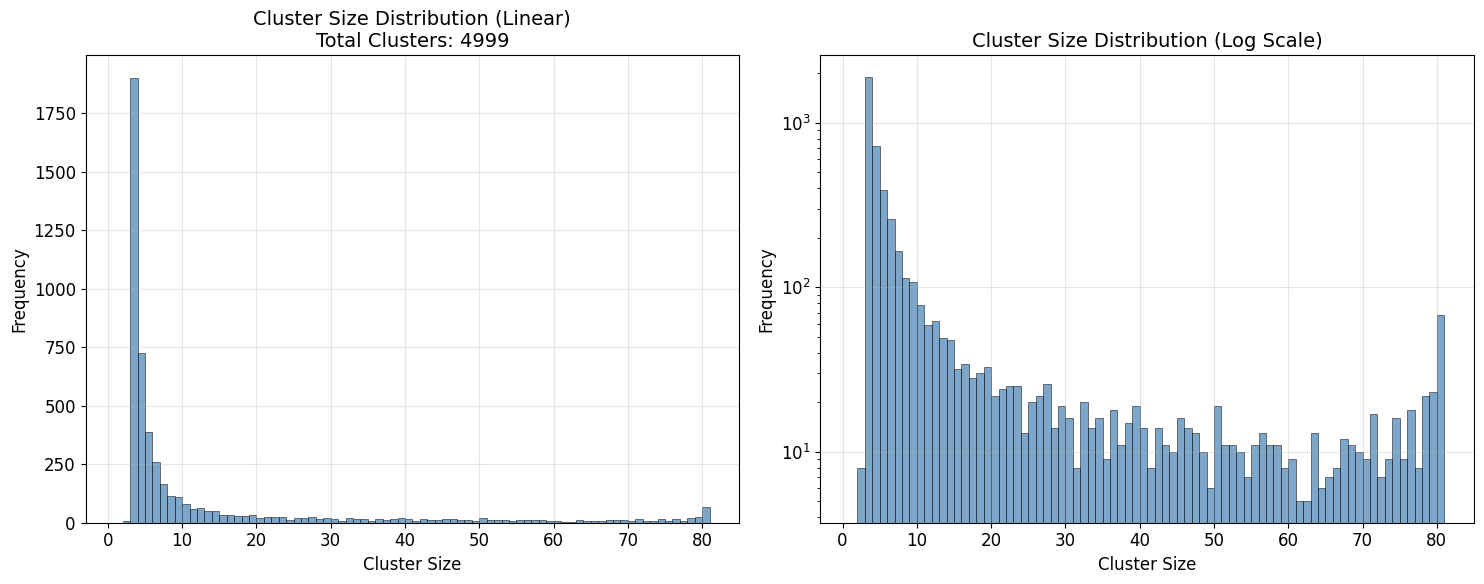

Cluster size statistics:
  Total clusters: 4999
  Mean size: 12.81
  Median size: 4.00
  Min size: 2
  Max size: 80
  Standard deviation: 18.85


In [5]:
# Cell: Cluster Size Distribution
if clusters_available and len(clusters) > 0:
    cluster_sizes = [cluster['cluster_size'] for cluster in clusters]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Linear scale histogram
    ax1.hist(cluster_sizes, bins=range(1, max(cluster_sizes) + 2), alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
    ax1.set_xlabel('Cluster Size', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title(f'Cluster Size Distribution (Linear)\nTotal Clusters: {len(clusters)}', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Log scale histogram
    ax2.hist(cluster_sizes, bins=range(1, max(cluster_sizes) + 2), alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
    ax2.set_xlabel('Cluster Size', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Cluster Size Distribution (Log Scale)', fontsize=14)
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Cluster size statistics:")
    print(f"  Total clusters: {len(cluster_sizes)}")
    print(f"  Mean size: {np.mean(cluster_sizes):.2f}")
    print(f"  Median size: {np.median(cluster_sizes):.2f}")
    print(f"  Min size: {min(cluster_sizes)}")
    print(f"  Max size: {max(cluster_sizes)}")
    print(f"  Standard deviation: {np.std(cluster_sizes):.2f}")

# Plot cluster locations (overview)

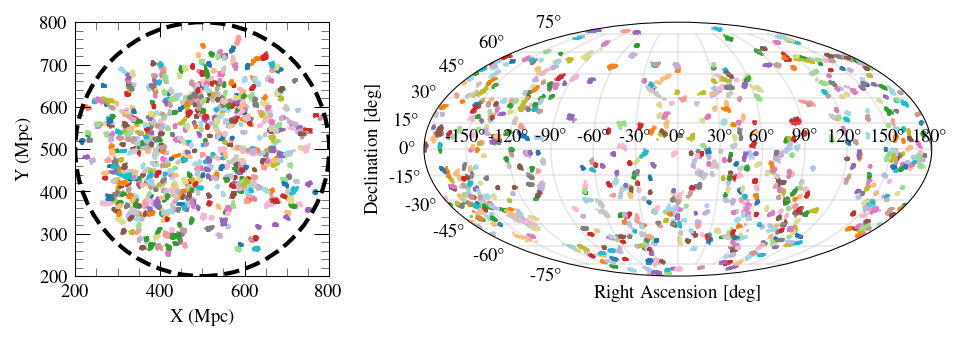

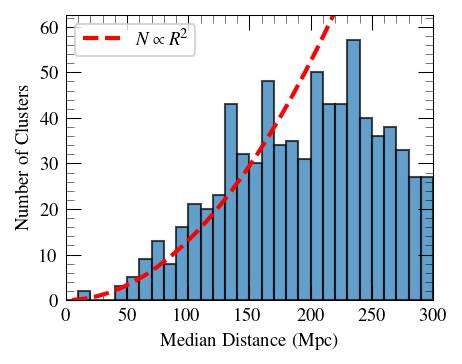

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import random

min_members_plot = 25

if clusters_available:
    with plt.style.context(get_mplstyle_path(mnras_style)):
        significant_clusters = [h for h in clusters if h['cluster_size'] >= min_members_plot]
        if len(significant_clusters) == 0:
            print(f"No clusters found with at least {min_members_plot} members")
        else:
            # ---- FIRST FIGURE: 2D XY and Mollweide projections ----
            fig = plt.figure(figsize=(6.5, 3.15))
            gs = fig.add_gridspec(1, 2, width_ratios=[1, 2])

            ax1 = fig.add_subplot(gs[0, 0])
            ax2 = fig.add_subplot(gs[0, 1], projection='mollweide')

            tab20_colors = plt.cm.tab20(np.linspace(0, 1, 20))
            random.seed(42)
            assigned_colors = random.choices(tab20_colors, k=len(significant_clusters))

            for i, cluster in enumerate(significant_clusters):
                positions = cluster['member_data']['BoundSubhalo/CentreOfMass']
                color = assigned_colors[i]
                ax1.scatter(positions[:, 0], positions[:, 1], c=[color], s=1, alpha=0.7, marker=".")

                # Mollweide expects longitude (ra) in [-pi, pi] and latitude (dec) in radians
                ra = np.asarray(cluster['member_data']['ra'])
                dec = np.asarray(cluster['member_data']['dec'])
                ra_wrapped = np.where(ra > 180, ra - 360, ra)  # wrap to [-180, 180]
                ra_rad = np.radians(ra_wrapped)
                dec_rad = np.radians(dec)
                ax2.scatter(ra_rad, dec_rad, c=[color], s=1, alpha=0.7, marker=".")

            # 2D plot formatting
            ax1.set_xlabel('X (Mpc)')
            ax1.set_ylabel('Y (Mpc)')
            circle = plt.Circle((500, 500), 300, fill=False, color='black', linestyle='--', linewidth=2)
            ax1.add_patch(circle)
            ax1.set_aspect('equal')

            # Mollweide formatting
            ax2.grid(True, alpha=0.3)
            # Set xticks in radians for Mollweide, with labels in degrees
            tick_labels = np.arange(-150, 181, 30)
            ax2.set_xticks(np.radians(tick_labels))
            ax2.set_xticklabels([f"{tl}°" for tl in tick_labels])
            ax2.set_xlabel('Right Ascension [deg]')
            ax2.set_ylabel('Declination [deg]')

            plt.tight_layout()
            plt.show()

            # ---- SECOND FIGURE: Histogram of Median Distances ----
            significant_median_distances = [
                np.median(cluster['member_data']['dist'])
                for cluster in significant_clusters
            ]
            fig, ax = plt.subplots(figsize=(3.15, 2.5))
            n, bins, patches = ax.hist(significant_median_distances, bins=np.arange(0,310,10),
                                       alpha=0.7, edgecolor='black')
            bin_centers = (bins[:-1] + bins[1:]) / 2
            r_squared_line = bin_centers**2
            scaling_factor = np.max(n) / np.max(r_squared_line)
            r_squared_line *= 2 * scaling_factor
            ax.plot(bin_centers, r_squared_line, 'r--', linewidth=2, label=r'$N \propto R^2$')
            ax.set_xlabel('Median Distance (Mpc)')
            ax.set_ylabel('Number of Clusters')
            ax.set_ylim(0, 1.1 * np.max(n))
            ax.legend()
            plt.tight_layout()
            plt.show()


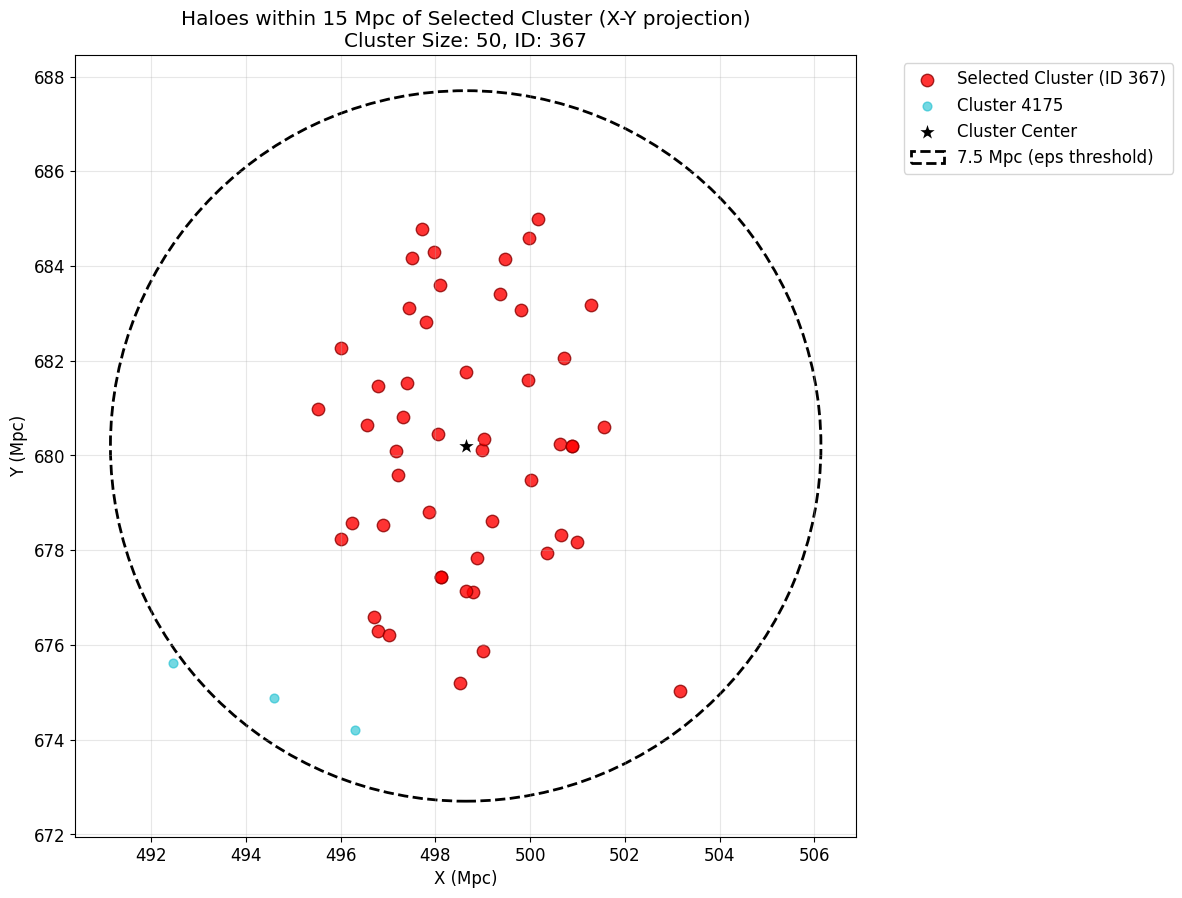

Selected cluster analysis:
  Cluster ID: 367
  Size: 50 members
  Center: [498.6, 680.2, 529.7]
  Mean mass: 1.99e+14
  Mass std: 1.04e+14


In [9]:
# Cell 6: Cluster Diagnostic Function
def plot_cluster_diagnostic(cluster_id=None):
    if not clusters_available or len(clusters) == 0:
        print("No clusters available for diagnostic plot")
        return
    
    # Find target cluster
    if cluster_id is None:
        target_cluster = max(clusters, key=lambda x: x['cluster_size'])
        cluster_type = "Largest"
    else:
        target_cluster = None
        for cluster in clusters:
            if cluster['cluster_id'] == cluster_id:
                target_cluster = cluster
                break
        
        if target_cluster is None:
            print(f"Cluster ID {cluster_id} not found")
            return
        cluster_type = "Selected"
    
    target_cluster_center = target_cluster['mean_position']
    target_cluster_id = target_cluster['cluster_id']
    
    all_positions = []
    all_cluster_ids = []
    
    for cluster in clusters:
        positions = cluster['member_data']['BoundSubhalo/CentreOfMass']
        cluster_id_val = cluster['cluster_id']
        all_positions.extend(positions)
        all_cluster_ids.extend([cluster_id_val] * len(positions))
    
    all_positions = np.array(all_positions)
    all_cluster_ids = np.array(all_cluster_ids)
    
    distances = np.linalg.norm(all_positions - target_cluster_center, axis=1)
    within_15mpc = distances <= 15.0
    
    nearby_positions = all_positions[within_15mpc]
    nearby_cluster_labels = all_cluster_ids[within_15mpc]
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    
    unique_labels = np.unique(nearby_cluster_labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        mask = nearby_cluster_labels == label
        if label == target_cluster_id:
            ax.scatter(nearby_positions[mask, 0], nearby_positions[mask, 1], 
                      c='red', s=80, alpha=0.8, label=f'{cluster_type} Cluster (ID {label})', edgecolors='darkred')
        else:
            ax.scatter(nearby_positions[mask, 0], nearby_positions[mask, 1], 
                      c=[colors[i]], s=40, alpha=0.6, label=f'Cluster {label}')
    
    ax.scatter(target_cluster_center[0], target_cluster_center[1], 
              c='black', s=300, marker='*', label='Cluster Center', edgecolors='white', linewidth=2)
    
    circle = plt.Circle((target_cluster_center[0], target_cluster_center[1]), 
                       7.5, fill=False, color='black', linestyle='--', linewidth=2, 
                       label='7.5 Mpc (eps threshold)')
    ax.add_patch(circle)
    
    ax.set_xlabel('X (Mpc)')
    ax.set_ylabel('Y (Mpc)')
    ax.set_title(f'Haloes within 15 Mpc of {cluster_type} Cluster (X-Y projection)\n'
                f'Cluster Size: {target_cluster["cluster_size"]}, ID: {target_cluster_id}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    print(f"{cluster_type} cluster analysis:")
    print(f"  Cluster ID: {target_cluster_id}")
    print(f"  Size: {target_cluster['cluster_size']} members")
    print(f"  Center: [{target_cluster_center[0]:.1f}, {target_cluster_center[1]:.1f}, {target_cluster_center[2]:.1f}]")
    print(f"  Mean mass: {target_cluster['mean_mass']:.2e}")
    print(f"  Mass std: {target_cluster['mass_std']:.2e}")

# Call the function - None for largest cluster, or specify cluster_id
plot_cluster_diagnostic(cluster_id=367)

In [10]:
# Cell 7: Temporal Evolution Setup
if traces_available:
    cluster_traces = defaultdict(list)
    for halo_key, trace_data in halo_traces.items():
        cluster_id = trace_data['cluster_id']
        cluster_traces[cluster_id].append(trace_data)
    
    # Filter clusters with sufficient traces
    min_traces_for_plot = 5  # Adjustable parameter
    significant_trace_clusters = {k: v for k, v in cluster_traces.items() 
                                 if len(v) >= min_traces_for_plot}
    
    print(f"Temporal evolution setup:")
    print(f"  Total clusters with traces: {len(cluster_traces)}")
    print(f"  Clusters with >= {min_traces_for_plot} traces: {len(significant_trace_clusters)}")
    
    # Sort by number of traces
    sorted_trace_clusters = sorted(significant_trace_clusters.items(), 
                                  key=lambda x: len(x[1]), reverse=True)
    
    print(f"\nTop clusters by trace count:")
    for cluster_id, traces in sorted_trace_clusters[:10]:
        print(f"  Cluster {cluster_id}: {len(traces)} traces")

Temporal evolution setup:
  Total clusters with traces: 767
  Clusters with >= 5 traces: 767

Top clusters by trace count:
  Cluster 384: 80 traces
  Cluster 392: 80 traces
  Cluster 395: 80 traces
  Cluster 409: 80 traces
  Cluster 407: 80 traces
  Cluster 439: 80 traces
  Cluster 448: 80 traces
  Cluster 450: 80 traces
  Cluster 464: 80 traces
  Cluster 465: 80 traces


In [15]:
# Cell 8a: Single Cluster Trajectory Plot Function
def plot_cluster_trajectory(cluster_id, ax=None):
    if not traces_available or cluster_id not in cluster_traces:
        print(f"No traces available for cluster {cluster_id}")
        return
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))
        standalone = True
    else:
        standalone = False
    
    traces = cluster_traces[cluster_id]
    
    # Calculate cluster centroid from final positions (snapshot 77)
    final_positions = []
    for trace_data in traces:
        positions = trace_data['BoundSubhalo/CentreOfMass']
        snapshots = trace_data['snapshots']
        final_idx = np.where(snapshots == 77)[0]
        if len(final_idx) > 0:
            final_positions.append(positions[final_idx[0]])
    
    if len(final_positions) > 0:
        final_positions = np.array(final_positions)
        cluster_centroid = np.mean(final_positions, axis=0)
    else:
        cluster_centroid = np.array([0, 0, 0])
    
    # Generate colors for each trajectory
    colors = plt.cm.tab20(np.linspace(0, 1, min(20, len(traces))))
    if len(traces) > 20:
        colors = plt.cm.gist_ncar(np.linspace(0, 1, len(traces)))
    
    for i, trace_data in enumerate(traces):
        positions = trace_data['BoundSubhalo/CentreOfMass']
        snapshots = trace_data['snapshots']
        
        # Plot trajectory line
        ax.plot(positions[:, 0], positions[:, 1], '-', 
               alpha=0.5, linewidth=0.8, color=colors[i])
        
        # Plot start and end points
        ax.scatter(positions[0, 0], positions[0, 1], 
                  c='red', s=40, marker='s', alpha=0.9, 
                  edgecolors='darkred', linewidth=0.3, zorder=10)
        ax.scatter(positions[-1, 0], positions[-1, 1], 
                  c='blue', s=40, marker='o', alpha=0.9,
                  edgecolors='darkblue', linewidth=0.3, zorder=10)
    
    # Add radial rings at 10 and 20 Mpc
    circle_10 = plt.Circle((cluster_centroid[0], cluster_centroid[1]), 
                          10, fill=False, color='gray', linestyle='--', 
                          linewidth=1, alpha=0.7)
    circle_20 = plt.Circle((cluster_centroid[0], cluster_centroid[1]), 
                          20, fill=False, color='gray', linestyle=':', 
                          linewidth=1, alpha=0.7)
    ax.add_patch(circle_10)
    ax.add_patch(circle_20)
    
    # Set axis limits to +/- 15 Mpc from cluster centroid
    ax.set_xlim(cluster_centroid[0] - 15, cluster_centroid[0] + 15)
    ax.set_ylim(cluster_centroid[1] - 15, cluster_centroid[1] + 15)
    
    ax.set_xlabel('X (Mpc)', fontsize=10)
    ax.set_ylabel('Y (Mpc)', fontsize=10)
    ax.set_title(f'Cluster {cluster_id} (n={len(traces)})', fontsize=12, pad=10)
    ax.set_aspect('equal')
    ax.set_facecolor('#f8f8f8')
    ax.grid(True, alpha=0.2, linewidth=0.5)
    ax.tick_params(labelsize=8)
    
    if standalone:
        plt.tight_layout()
        plt.show()

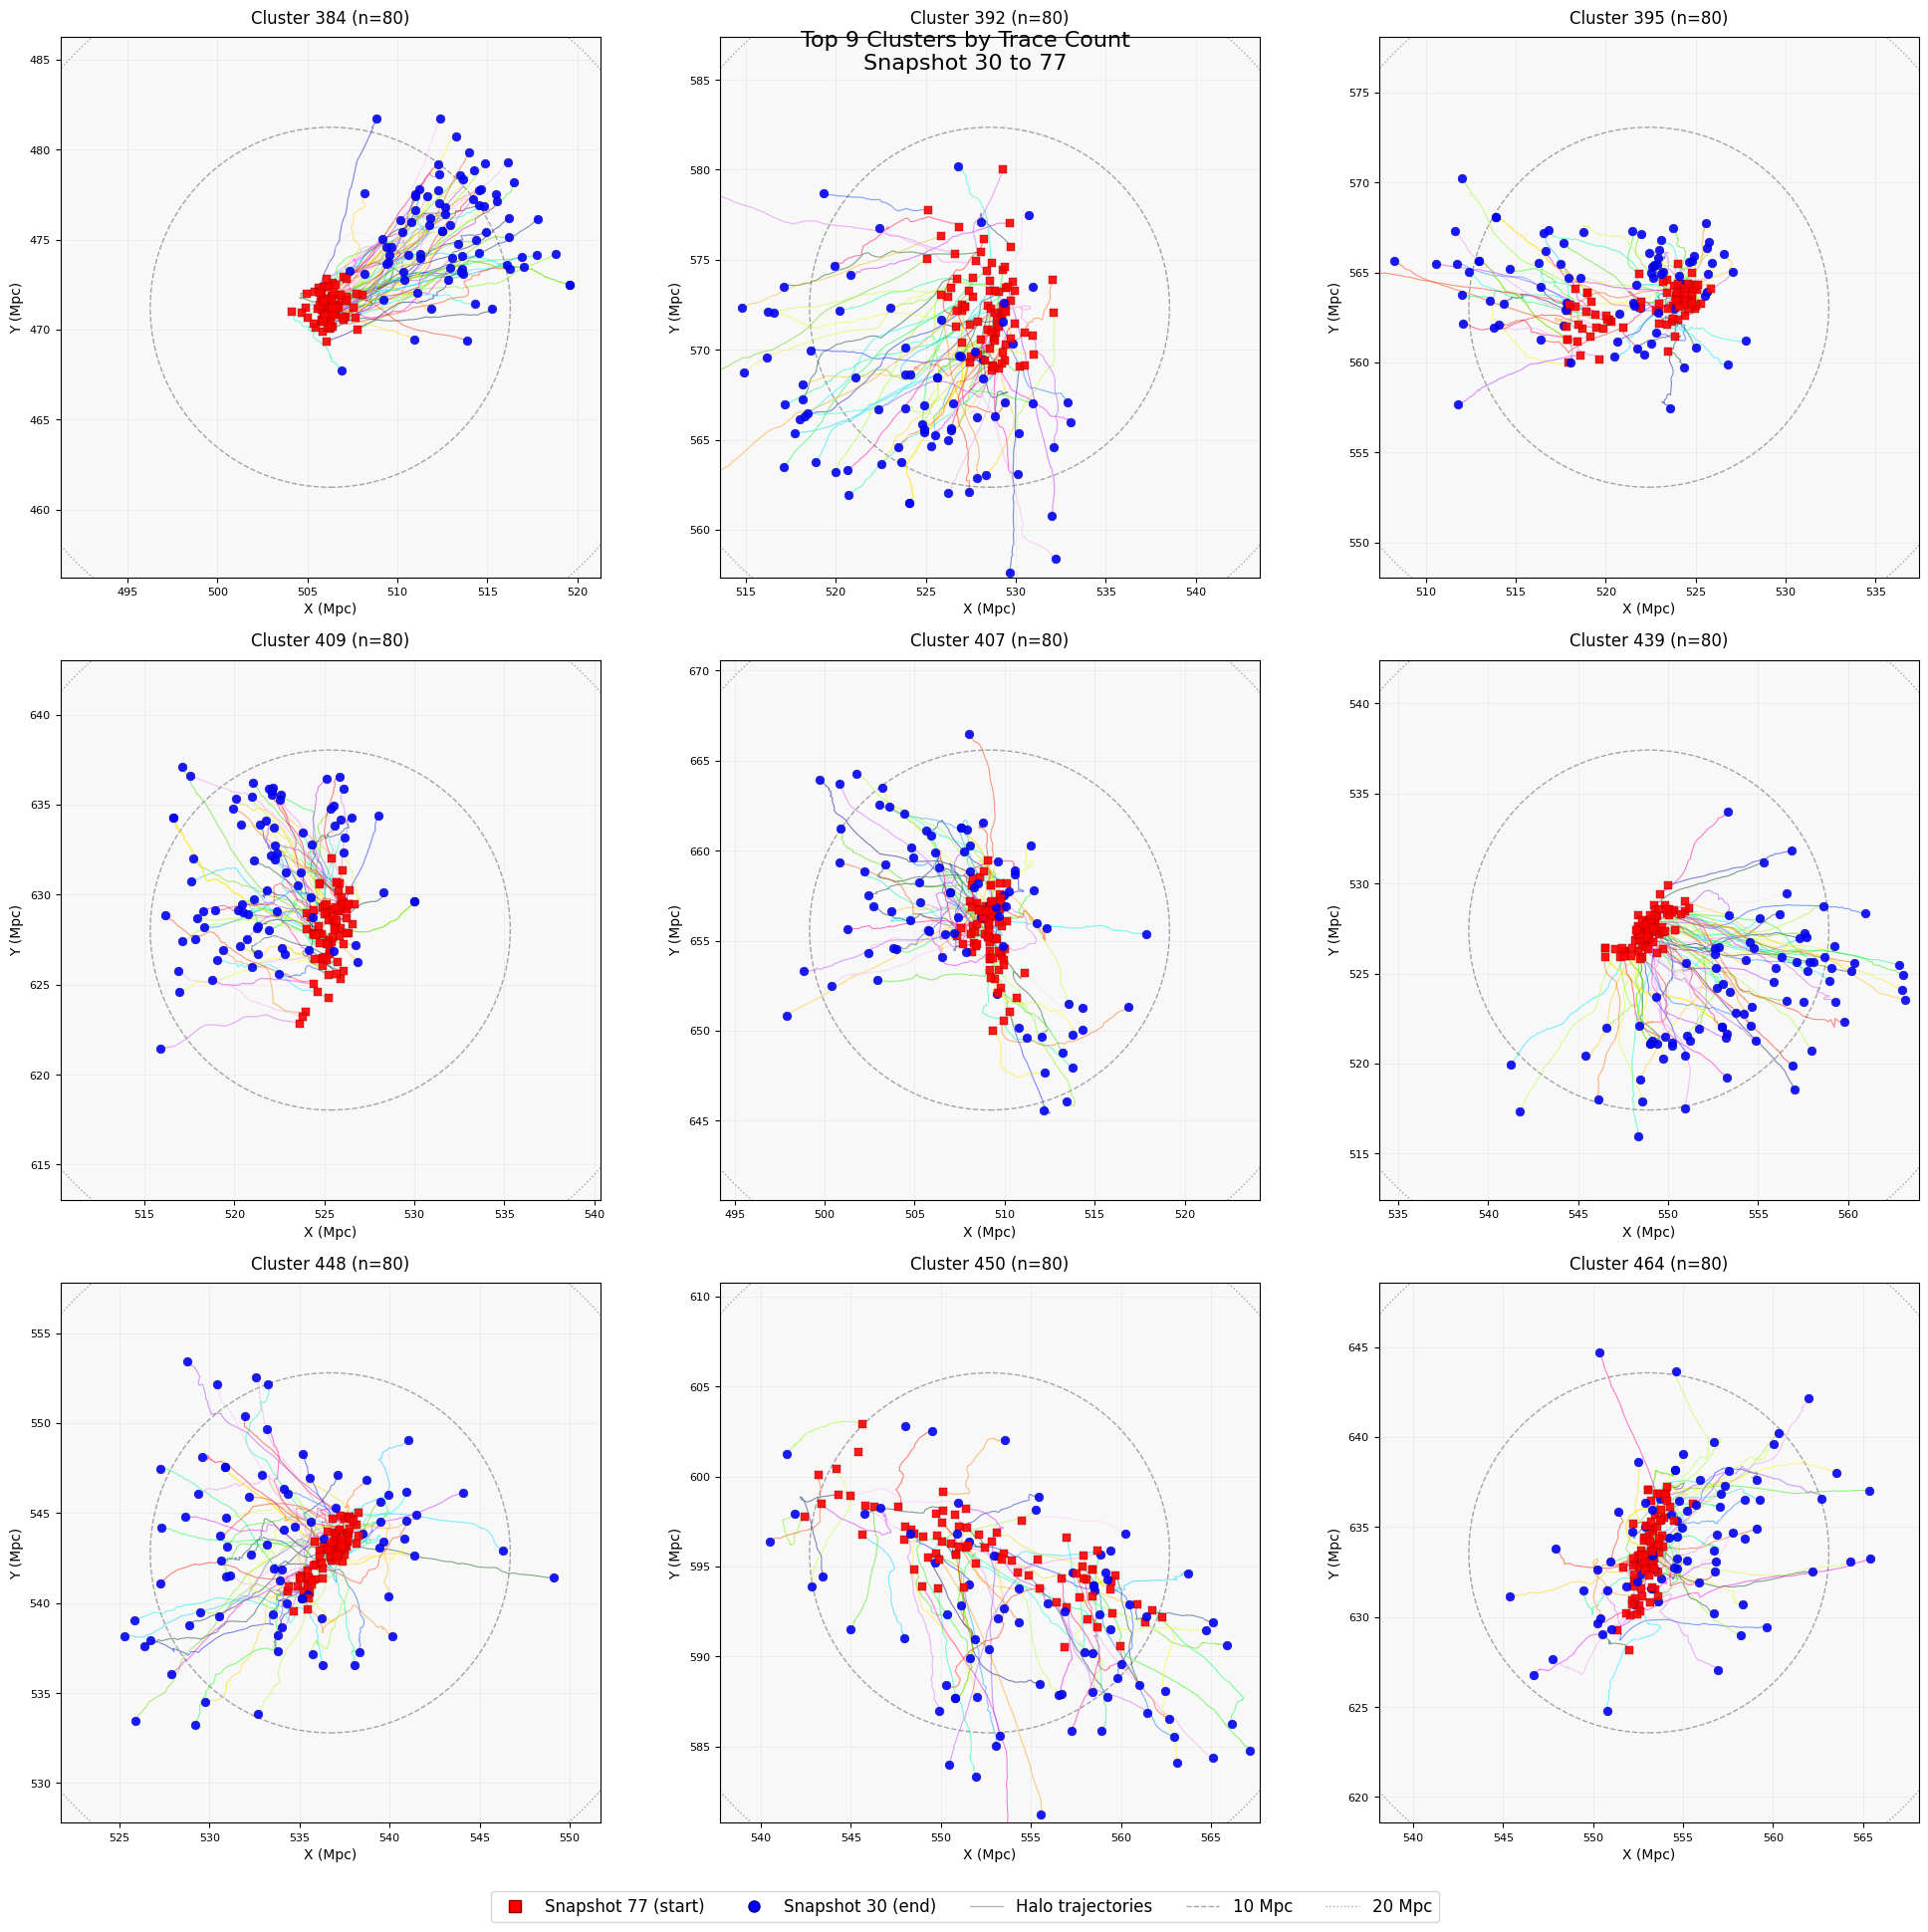

In [16]:
# Cell 8b: Top 9 Cluster Trajectory Plots (3x3 Grid)
if traces_available and len(significant_trace_clusters) > 0:
    # Plot top 9 clusters in 3x3 grid
    n_clusters_to_plot = min(9, len(sorted_trace_clusters))
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    axes = axes.flatten()
    
    for plot_idx in range(n_clusters_to_plot):
        cluster_id, traces = sorted_trace_clusters[plot_idx]
        ax = axes[plot_idx]
        plot_cluster_trajectory(cluster_id, ax=ax)
    
    # Hide unused subplots
    for plot_idx in range(n_clusters_to_plot, 9):
        axes[plot_idx].set_visible(False)
    
    # Add overall legend
    fig.legend([plt.Line2D([0], [0], marker='s', color='red', linestyle='None', markersize=8, markeredgecolor='darkred'),
                plt.Line2D([0], [0], marker='o', color='blue', linestyle='None', markersize=8, markeredgecolor='darkblue'),
                plt.Line2D([0], [0], color='gray', alpha=0.6, linewidth=1.0),
                plt.Line2D([0], [0], color='gray', linestyle='--', linewidth=1, alpha=0.7),
                plt.Line2D([0], [0], color='gray', linestyle=':', linewidth=1, alpha=0.7)],
               [f'Snapshot 77 (start)', f'Snapshot {config.mode2.target_snapshot} (end)', 'Halo trajectories', '10 Mpc', '20 Mpc'],
               loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=5, fontsize=12)
    
    plt.suptitle(f'Top {n_clusters_to_plot} Clusters by Trace Count\nSnapshot {config.mode2.target_snapshot} to 77', 
                 fontsize=16, y=0.95)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.05)
    plt.show()

In [23]:
# Cell: Single Cluster Mass Distribution Function
def plot_cluster_mass_distribution(cluster_id, ax=None):
    if not clusters_available:
        print(f"No clusters available")
        return
    
    # Find the cluster
    target_cluster = None
    for cluster in clusters:
        if cluster['cluster_id'] == cluster_id:
            target_cluster = cluster
            break
    
    if target_cluster is None:
        print(f"Cluster ID {cluster_id} not found")
        return
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        standalone = True
    else:
        standalone = False
    
    cluster_masses = target_cluster['member_data']['BoundSubhalo/TotalMass']
    cluster_size = target_cluster['cluster_size']
    median_mass = np.median(cluster_masses)
    mean_mass = target_cluster['mean_mass']
    
    # Plot histogram of masses
    ax.hist(cluster_masses, bins=10**np.arange(13.8,15.5,0.05), alpha=0.7, color='skyblue', edgecolor='black', linewidth=0.5)
    
    # Add vertical lines for mean and median
    ax.axvline(mean_mass, color='red', linestyle='--', linewidth=2, alpha=0.8, label=f'Mean: {mean_mass:.2e}')
    ax.axvline(median_mass, color='orange', linestyle='-', linewidth=2, alpha=0.8, label=f'Median: {median_mass:.2e}')
    
    ax.set_xlabel('Mass (M☉)', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'Cluster {cluster_id} (n={cluster_size})', fontsize=12, pad=10)
    ax.tick_params(labelsize=8)
    ax.grid(True, alpha=0.3, linewidth=0.5)
    ax.set_xscale("log")
    ax.legend(fontsize=8)
    
    if standalone:
        plt.tight_layout()
        plt.show()

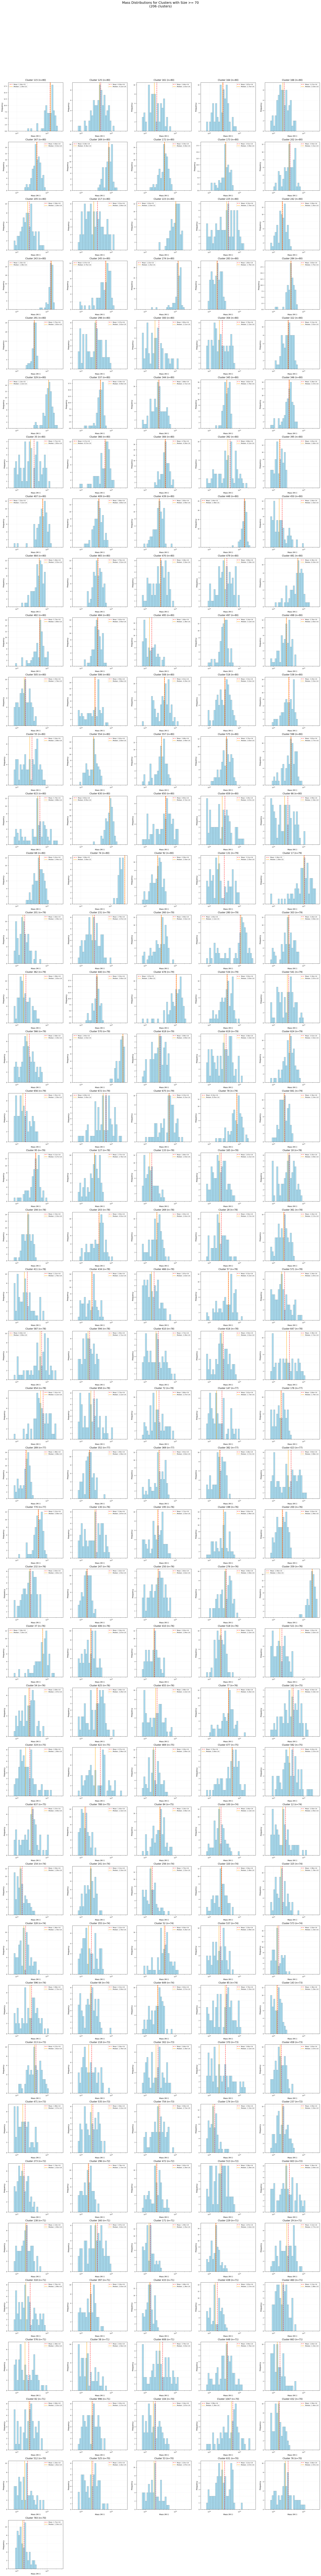

In [24]:
# Cell: Mass Distributions for Clusters Above Size Threshold (5xN Grid)
if clusters_available and len(clusters) > 0:
    # Set cluster size threshold
    cluster_size_threshold = 70  # Adjustable parameter
    
    # Filter clusters by size
    large_clusters = [cluster for cluster in clusters if cluster['cluster_size'] >= cluster_size_threshold]
    
    if len(large_clusters) == 0:
        print(f"No clusters found with size >= {cluster_size_threshold}")
    else:
        # Calculate grid dimensions (5 columns, as many rows as needed)
        n_cols = 5
        n_rows = (len(large_clusters) + n_cols - 1) // n_cols  # Ceiling division
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
        
        # Handle case where there's only one row
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        axes = axes.flatten()
        
        # Sort by cluster size descending
        large_clusters.sort(key=lambda c: c['cluster_size'], reverse=True)
        
        for plot_idx in range(len(large_clusters)):
            cluster = large_clusters[plot_idx]
            ax = axes[plot_idx]
            plot_cluster_mass_distribution(cluster['cluster_id'], ax=ax)
        
        # Hide unused subplots
        for plot_idx in range(len(large_clusters), n_rows * n_cols):
            axes[plot_idx].set_visible(False)
        
        plt.suptitle(f'Mass Distributions for Clusters with Size >= {cluster_size_threshold}\n({len(large_clusters)} clusters)', fontsize=18, y=0.95)
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()

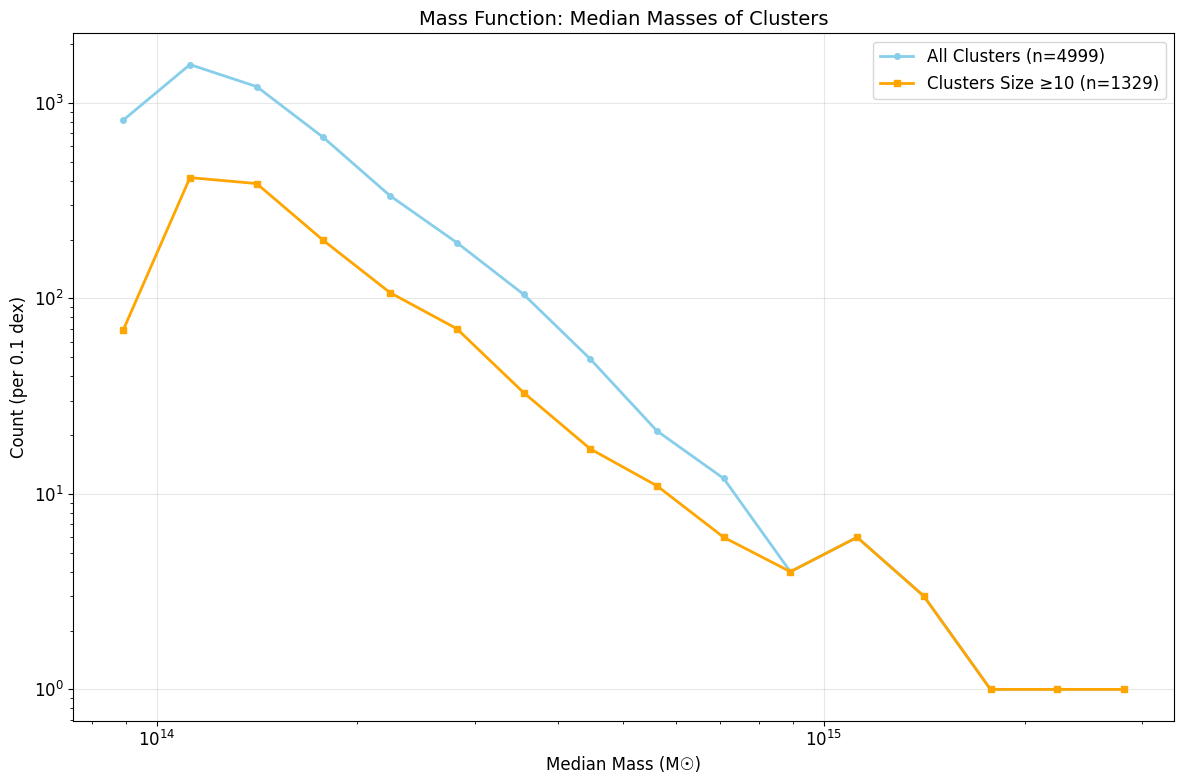

Mass function statistics:
  All clusters:
    Count: 4999
    Median of medians: 1.28e+14
    Mean of medians: 1.53e+14
    Min median mass: 8.00e+13
    Max median mass: 3.09e+15
  Large clusters (size ≥10):
    Count: 1329
    Median of medians: 1.39e+14
    Mean of medians: 1.78e+14
    Min median mass: 8.63e+13
    Max median mass: 3.09e+15


In [22]:
# Cell: Mass Function Comparison
if clusters_available and len(clusters) > 0:
    # Set cluster size threshold
    cluster_size_threshold = 10  # Adjustable parameter
    
    # Calculate median masses for all clusters
    all_median_masses = []
    for cluster in clusters:
        cluster_masses = cluster['member_data']['BoundSubhalo/TotalMass']
        median_mass = np.median(cluster_masses)
        all_median_masses.append(median_mass)
    
    # Calculate median masses for clusters above threshold
    large_cluster_median_masses = []
    for cluster in clusters:
        if cluster['cluster_size'] >= cluster_size_threshold:
            cluster_masses = cluster['member_data']['BoundSubhalo/TotalMass']
            median_mass = np.median(cluster_masses)
            large_cluster_median_masses.append(median_mass)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    if len(all_median_masses) > 0 and len(large_cluster_median_masses) > 0:
        # Convert to log10 for binning
        all_log_masses = np.log10(all_median_masses)
        large_log_masses = np.log10(large_cluster_median_masses)
        
        # Create bins with 0.1 dex spacing
        min_log_mass = min(np.min(all_log_masses), np.min(large_log_masses))
        max_log_mass = max(np.max(all_log_masses), np.max(large_log_masses))
        bins = np.arange(np.floor(min_log_mass * 10) / 10, np.ceil(max_log_mass * 10) / 10 + 0.1, 0.1)
        
        # Calculate histograms
        all_counts, _ = np.histogram(all_log_masses, bins=bins)
        large_counts, _ = np.histogram(large_log_masses, bins=bins)
        
        # Calculate bin centers
        bin_centers = (bins[:-1] + bins[1:]) / 2
        bin_centers_linear = 10**bin_centers
        
        # Plot lines
        ax.plot(bin_centers_linear, all_counts, '-o', linewidth=2, markersize=4, 
               label=f'All Clusters (n={len(all_median_masses)})', color='skyblue')
        ax.plot(bin_centers_linear, large_counts, '-s', linewidth=2, markersize=4,
               label=f'Clusters Size ≥{cluster_size_threshold} (n={len(large_cluster_median_masses)})', color='orange')
    
    ax.set_xlabel('Median Mass (M☉)', fontsize=12)
    ax.set_ylabel('Count (per 0.1 dex)', fontsize=12)
    ax.set_title('Mass Function: Median Masses of Clusters', fontsize=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Mass function statistics:")
    if len(all_median_masses) > 0:
        print(f"  All clusters:")
        print(f"    Count: {len(all_median_masses)}")
        print(f"    Median of medians: {np.median(all_median_masses):.2e}")
        print(f"    Mean of medians: {np.mean(all_median_masses):.2e}")
        print(f"    Min median mass: {min(all_median_masses):.2e}")
        print(f"    Max median mass: {max(all_median_masses):.2e}")
    
    if len(large_cluster_median_masses) > 0:
        print(f"  Large clusters (size ≥{cluster_size_threshold}):")
        print(f"    Count: {len(large_cluster_median_masses)}")
        print(f"    Median of medians: {np.median(large_cluster_median_masses):.2e}")
        print(f"    Mean of medians: {np.mean(large_cluster_median_masses):.2e}")
        print(f"    Min median mass: {min(large_cluster_median_masses):.2e}")
        print(f"    Max median mass: {max(large_cluster_median_masses):.2e}")

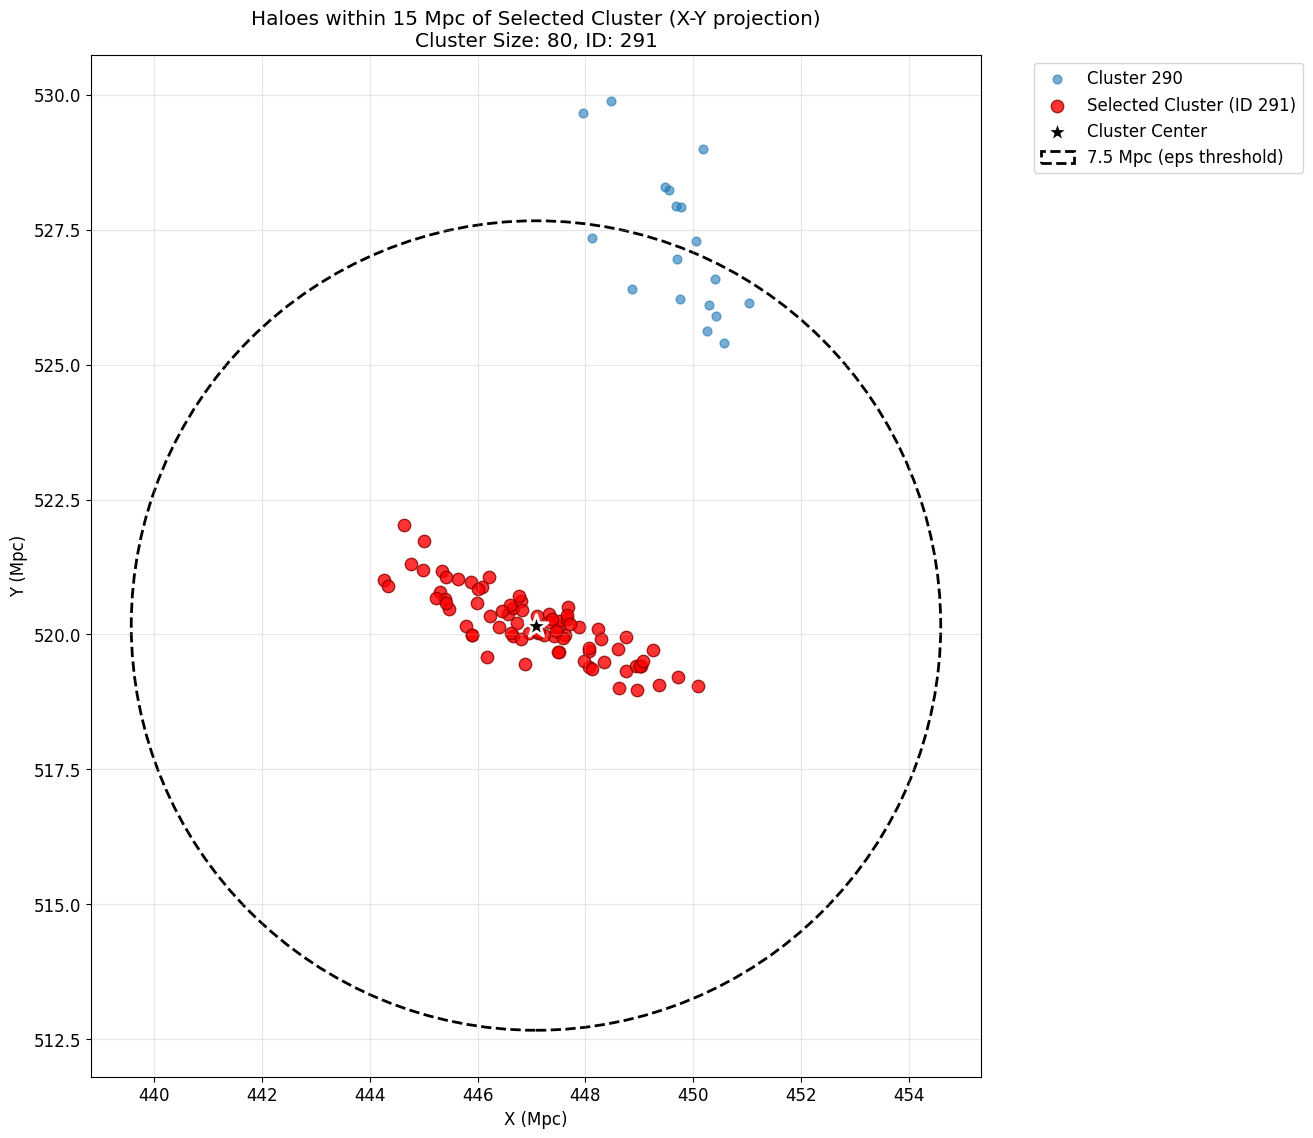

Selected cluster analysis:
  Cluster ID: 291
  Size: 80 members
  Center: [447.1, 520.2, 470.4]
  Mean mass: 3.75e+14
  Mass std: 6.08e+13


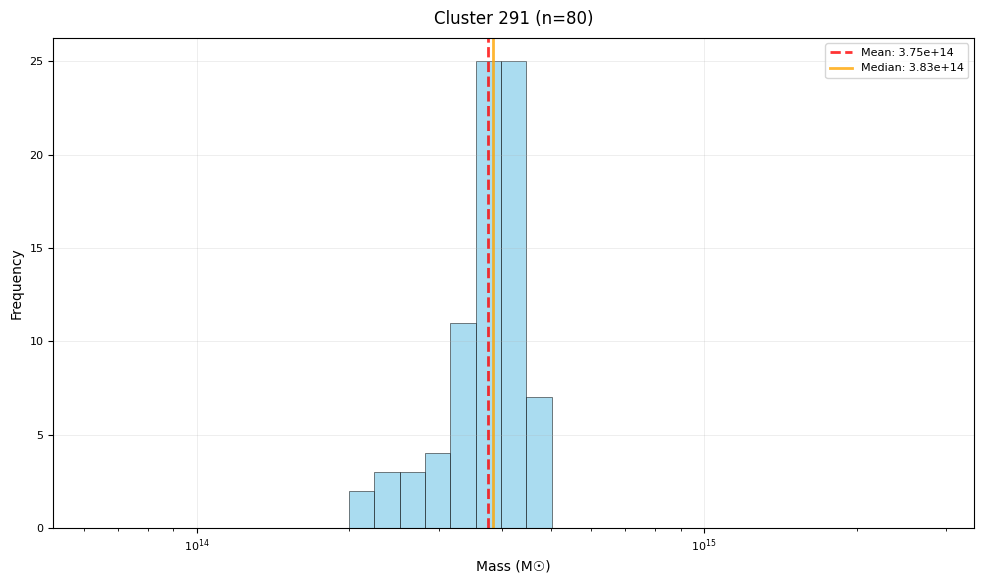

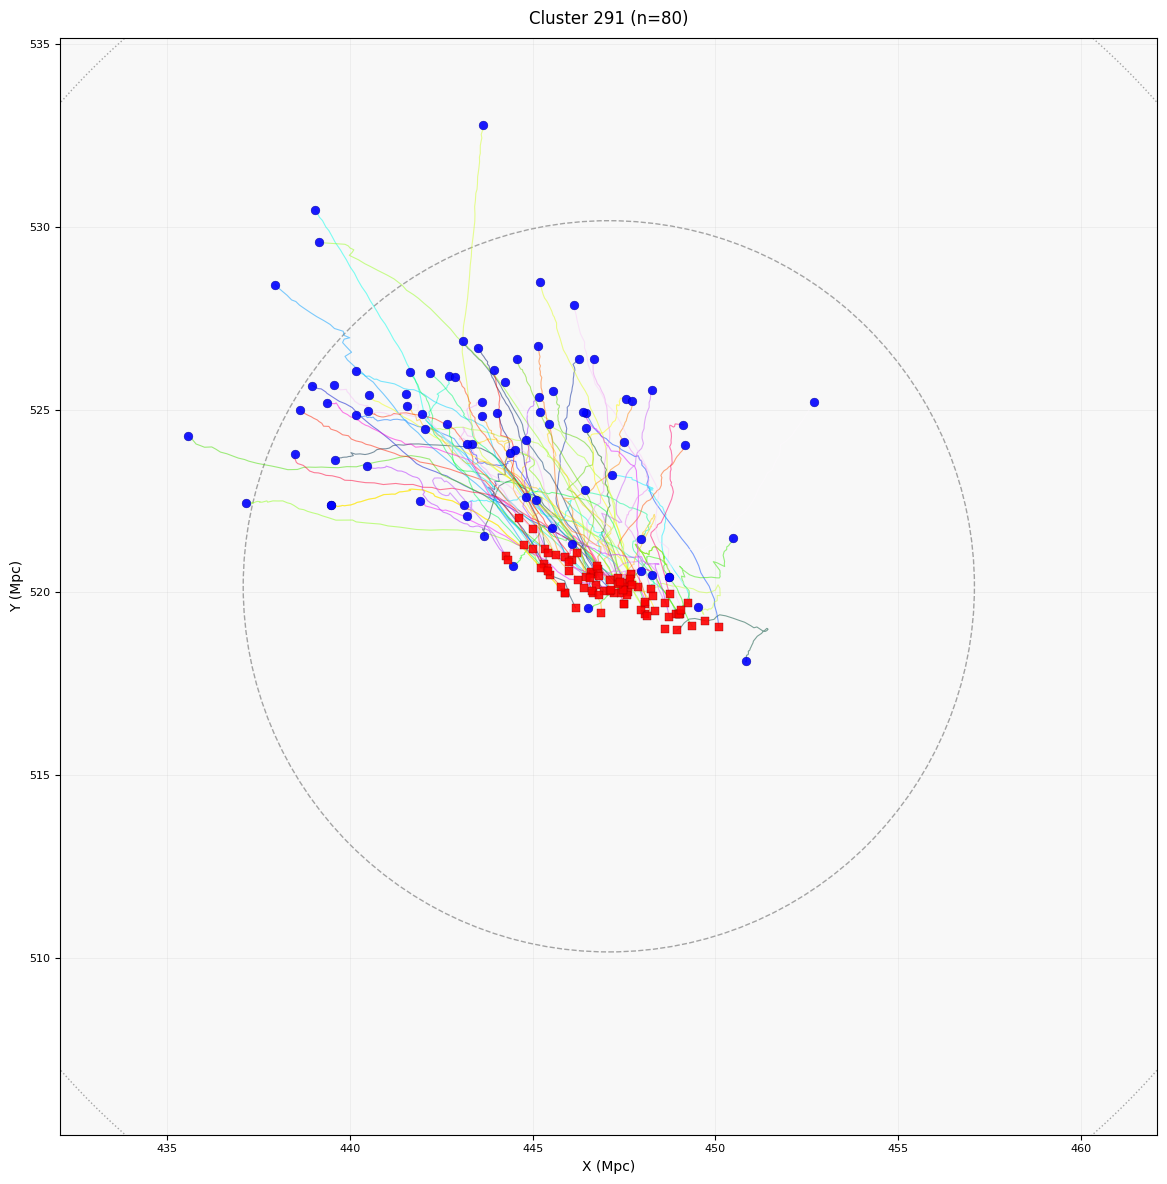

In [25]:
cluster_id = 291
plot_cluster_diagnostic(cluster_id=cluster_id)
plot_cluster_mass_distribution(cluster_id=cluster_id)
plot_cluster_trajectory(cluster_id=cluster_id)